In [66]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

In [69]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [70]:
info_col_cl =  info_col+['class']

In [92]:
data_imp_v2 = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv' , index_col='obs_id')
#starting_with_small_subset
#data_imp_v2 = pd.read_csv('imputed_data/small-feat-subset-new-data.csv', index_col='obs_id')

In [93]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


In [77]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_inter_sigma_s,var_inter_index_m,var_inter_index_s,var_inter_index_h,flux_aper_hilim_u,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,2.546000e-05,4.997917,5.00,4.995833,13.180832,0.002783,0.000731,0.745155,0.615729,9.076243e-05
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,9.067000e-07,0.000000,5.00,5.000000,14.414469,0.001892,0.000543,0.636986,0.600328,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,1.158000e-06,4.000000,0.00,0.000000,14.725442,0.000976,0.000229,0.651185,0.605873,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,9.192000e-07,8.000000,6.00,6.000000,14.427746,0.003526,0.000332,0.393800,0.247778,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,5.081000e-07,4.000000,0.00,8.000000,14.832036,0.002833,0.000543,0.677423,0.619311,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,3.385778e-06,2.250000,4.96,1.610000,14.159831,0.003456,0.000029,0.829000,0.084000,3.013343e-06
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,2.082304e-07,2.330000,3.43,1.810000,14.612610,0.001171,0.000255,0.265000,0.807000,6.861258e-07
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,5.992000e-09,5.000000,3.26,1.440000,15.247567,0.001623,0.000211,0.735000,0.451000,8.933566e-07


In [78]:
df_comb.to_csv('combined_data-small-subset.csv')

In [79]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_inter_sigma_s,var_inter_index_m,var_inter_index_s,var_inter_index_h,flux_aper_hilim_u,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.033363,0.313750,0.446753,0.297412,-1.634728,-0.406890,-0.079098,0.668425,0.786527,-0.053310
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,-0.087445,-1.589881,0.446753,0.298909,0.021879,-0.474481,-0.139832,0.201459,0.723266,-0.097230
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,-0.086208,-0.066341,-1.457148,-1.497596,0.439473,-0.544067,-0.241305,0.262757,0.746042,-0.097180
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,-0.087383,1.457198,0.827534,0.658210,0.039708,-0.350470,-0.208177,-0.848377,-0.724840,-0.097324
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,-0.089406,-0.066341,-1.457148,1.376812,0.582615,-0.403078,-0.139974,0.376027,0.801240,-0.097171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,-0.075247,-0.732890,0.431522,-0.919122,-0.320065,-0.355798,-0.306083,1.030387,-1.397560,-0.096235
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,-0.090882,-0.702419,-0.151072,-0.847262,0.287956,-0.529235,-0.232873,-1.404408,1.572178,-0.097373
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,-0.091877,0.314544,-0.215804,-0.980203,1.140617,-0.494927,-0.247119,0.624588,0.109900,-0.097272


In [80]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (420, 29)
Number of sources : 
CV  	  184 	 184
PL  	  178 	 178
LX  	  58 	 58


In [81]:
from sklearn.ensemble import AdaBoostClassifier

In [82]:
verbose = 0
val_acc = []
test_acc = []
rs = 999
for i in tqdm(range(10)):
    rs = int(np.random.randint(0,99999))
    #rs = 13186
    np.random.seed(rs)
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val,random_state=42 )
    #clf = RandomForestClassifier(n_estimators=500 , )
    clf = RandomForestClassifier(n_estimators=100  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
    #clf =AdaBoostClassifier(base_estimator=clf)
    #oversample = SMOTE(k_neighbors=10 , n_jobs=-1)
    #x_train , y_train = oversample.fit_resample(x_train , y_train)
    clf.fit(x_train , y_train ,)
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(rs ,  v_sc)

 10%|█         | 1/10 [00:00<00:03,  2.65it/s]

50777 0.7301587301587301


 20%|██        | 2/10 [00:00<00:02,  2.97it/s]

16307 0.6984126984126984


 30%|███       | 3/10 [00:01<00:02,  2.71it/s]

12949 0.7063492063492064


 40%|████      | 4/10 [00:01<00:02,  2.57it/s]

14056 0.6746031746031746


 50%|█████     | 5/10 [00:01<00:01,  2.50it/s]

44375 0.6984126984126984


 60%|██████    | 6/10 [00:02<00:01,  2.72it/s]

94809 0.6587301587301587


 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

87522 0.6984126984126984


 80%|████████  | 8/10 [00:02<00:00,  3.23it/s]

25356 0.6825396825396826


 90%|█████████ | 9/10 [00:03<00:00,  3.40it/s]

36515 0.7142857142857143


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

41672 0.7063492063492064


In [83]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,98.843537,69.682540
std,0.175646,2.042355
min,98.639456,65.873016
max,98.979592,73.015873


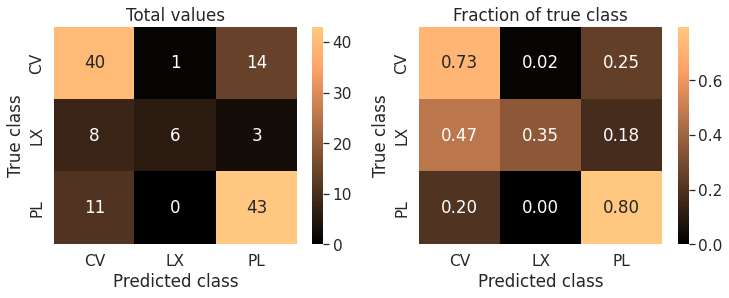

In [84]:
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols= 2 , figsize = (12 , 4))
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[0] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
cf = confusion_matrix(y_test , clf.predict(x_test) ,normalize='true')
sns.heatmap(cf , annot=True ,fmt = '.2f' , ax = ax[1] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
ax[0].set_title('Total values')
ax[1].set_title('Fraction of true class')
for a in ax:
    a.set_xlabel('Predicted class')small subset

In [85]:
y_pred_prob = [np.amax(pi) for pi in clf.predict_proba(x_train)]
y_pred_class = clf.predict(x_train)
y_pred_prob = pd.DataFrame({'pred_class': y_pred_class , 'pred_prob' :y_pred_prob})
#y_pred_prob  = y_pred_prob.melt().rename({'variable' : 'class' , 'value' : 'pred_prob'} , axis=1)
y_pred_prob

,pred_class,pred_prob
0,PL,0.521416
1,CV,0.855426
2,CV,0.805306
3,PL,0.780554
4,PL,0.869208
...,...,...
289,LX,0.923596
290,LX,0.754167
291,LX,0.614106
292,CV,0.700860


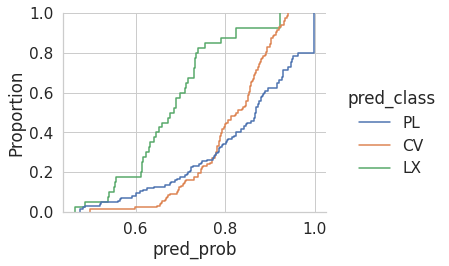

In [86]:
sns.displot(
    data = y_pred_prob , 
    x = 'pred_prob' , 
    hue = 'pred_class' , 
    kind='ecdf',
    height= 4 ,
    aspect= 10/8
)
plt.show()

In [87]:
from sklearn.metrics import precision_score , recall_score

In [88]:
y_pred = clf.predict(x_test)
ps = precision_score(y_test , y_pred , average = None) 
rc = recall_score(y_test , y_pred , average = None)
sc = pd.DataFrame({
    'precision' : ps , 
    'recall' : rc , 
    } ,  index=['CV' , 'LMXB' , 'PULSAR'])
sc 

,precision,recall
CV,0.677966,0.727273
LMXB,0.857143,0.352941
PULSAR,0.716667,0.796296


# SMOTE

In [89]:
from imblearn.over_sampling import SMOTE

In [90]:
verbose = 0
val_acc = []
test_acc = []
rs = 999
for i in tqdm(range(32)):
    rs = int(np.random.randint(0,99999))
    #rs = 39440
    #rs = 57865
    np.random.seed(rs)
    src_list = pd.DataFrame()
    #class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val, random_state=42)
    #clf = RandomForestClassifier(n_estimators=200 , )
    clf = RandomForestClassifier(n_estimators=100  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True , random_state=42)
    #clf = AdaBoostClassifier(base_estimator=clf ,)
    oversample = SMOTE(k_neighbors=10 , n_jobs=-1)
    x_train , y_train = oversample.fit_resample(x_train , y_train)

    clf.fit(x_train , y_train)
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(rs ,  v_sc)

  3%|▎         | 1/32 [00:00<00:13,  2.22it/s]

13638 0.7063492063492064


  6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

81653 0.6746031746031746


  9%|▉         | 3/32 [00:01<00:13,  2.20it/s]

54807 0.6904761904761905


 12%|█▎        | 4/32 [00:01<00:11,  2.39it/s]

16536 0.6904761904761905


 16%|█▌        | 5/32 [00:02<00:10,  2.57it/s]

45840 0.7063492063492064


 19%|█▉        | 6/32 [00:02<00:10,  2.45it/s]

24362 0.6825396825396826


 22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

47784 0.6984126984126984


 25%|██▌       | 8/32 [00:03<00:10,  2.39it/s]

42113 0.6507936507936508


 28%|██▊       | 9/32 [00:03<00:09,  2.52it/s]

75564 0.6825396825396826


 31%|███▏      | 10/32 [00:04<00:08,  2.62it/s]

46316 0.6984126984126984


 34%|███▍      | 11/32 [00:04<00:08,  2.56it/s]

60337 0.6507936507936508


 38%|███▊      | 12/32 [00:04<00:08,  2.50it/s]

99468 0.7063492063492064


 41%|████      | 13/32 [00:05<00:07,  2.61it/s]

26468 0.7222222222222222


 44%|████▍     | 14/32 [00:05<00:06,  2.71it/s]

10916 0.6904761904761905


 47%|████▋     | 15/32 [00:05<00:06,  2.80it/s]

3139 0.746031746031746


 50%|█████     | 16/32 [00:06<00:05,  2.81it/s]

92733 0.6587301587301587


 53%|█████▎    | 17/32 [00:06<00:05,  2.74it/s]

77471 0.7142857142857143


 56%|█████▋    | 18/32 [00:06<00:04,  2.83it/s]

55107 0.6746031746031746


 59%|█████▉    | 19/32 [00:07<00:04,  2.87it/s]

21323 0.6904761904761905


 62%|██████▎   | 20/32 [00:07<00:04,  2.91it/s]

58768 0.6666666666666666


 66%|██████▌   | 21/32 [00:08<00:03,  2.84it/s]

41321 0.6904761904761905


 69%|██████▉   | 22/32 [00:08<00:03,  2.88it/s]

76721 0.6825396825396826


 72%|███████▏  | 23/32 [00:08<00:03,  2.82it/s]

83261 0.6825396825396826


 75%|███████▌  | 24/32 [00:09<00:02,  2.88it/s]

44747 0.6984126984126984


 78%|███████▊  | 25/32 [00:09<00:02,  2.89it/s]

12863 0.6904761904761905


 81%|████████▏ | 26/32 [00:09<00:02,  2.93it/s]

67208 0.6746031746031746


 84%|████████▍ | 27/32 [00:10<00:01,  2.86it/s]

13097 0.6666666666666666


 88%|████████▊ | 28/32 [00:10<00:01,  2.87it/s]

75371 0.6825396825396826


 91%|█████████ | 29/32 [00:10<00:01,  2.90it/s]

94228 0.7063492063492064


 94%|█████████▍| 30/32 [00:11<00:00,  2.99it/s]

79350 0.6904761904761905


 97%|█████████▋| 31/32 [00:11<00:00,  3.00it/s]

40394 0.6746031746031746


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]

18285 0.6746031746031746


In [91]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,99.216731,68.799603
std,0.045679,2.010197
min,98.966408,65.079365
max,99.224806,74.603175


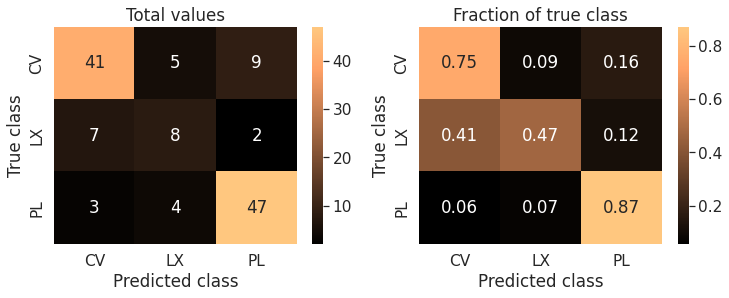

In [32]:
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols= 2 , figsize = (12 , 4))
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[0] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
cf = confusion_matrix(y_test , clf.predict(x_test) ,normalize='true')
sns.heatmap(cf , annot=True ,fmt = '.2f' , ax = ax[1] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper' )
ax[0].set_title('Total values')
ax[1].set_title('Fraction of true class')
for a in ax:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')
plt.show()
#score

In [33]:
y_pred = clf.predict(x_test)
ps = precision_score(y_test , y_pred , average = None) 
rc = recall_score(y_test , y_pred , average = None)
sc = pd.DataFrame({
    'precision' : ps , 
    'recall' : rc , 
    } ,  index=['CV' , 'LMXB' , 'PULSAR'])
sc 

,precision,recall
CV,0.803922,0.745455
LMXB,0.470588,0.470588
PULSAR,0.810345,0.870370


## ECDF plot

In [34]:
y_pred_prob = [np.amax(pi) for pi in clf.predict_proba(x_train)]
y_pred_class = clf.predict(x_train)
y_pred_prob = pd.DataFrame({'pred_class': y_pred_class , 'pred_prob' :y_pred_prob})
#y_pred_prob  = y_pred_prob.melt().rename({'variable' : 'class' , 'value' : 'pred_prob'} , axis=1)
y_pred_prob

,pred_class,pred_prob
0,PL,0.521490
1,CV,0.927584
2,CV,0.727380
3,PL,0.805956
4,PL,0.858386
...,...,...
382,PL,0.684533
383,PL,0.902765
384,PL,0.841919
385,PL,0.688270


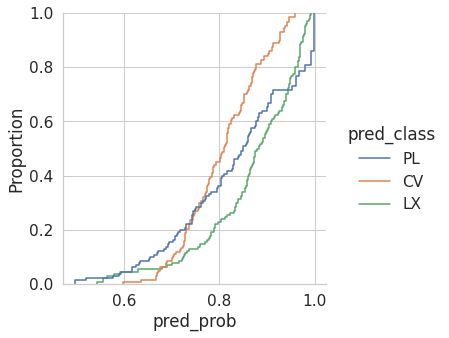

In [35]:
sns.displot(
    data = y_pred_prob , 
    x = 'pred_prob' , 
    hue = 'pred_class' , 
    kind='ecdf'
)
plt.show()

# Hyper Parameter Tuning

In [36]:
def calculate_score(clf , df):
    verbose = 0
    val_acc = []
    test_acc = []
    #clf = sent_clf.copy()
    rs = 999
    for i in (range(16)):
        rs = int(np.random.randint(0,99999))
        #rs = 13186
        np.random.seed(rs)
        src_list = pd.DataFrame()
        class_to_select = ['CV' , 'LX' , 'PL']
        #df = data_imp_norm.copy()
        i_val = df[info_col]
        y_val = df['class']
        x_val = df.drop(columns=['class']+info_col)
        x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val, random_state=42)
        
        clf.fit(x_train , y_train ,sample_weight=i_train['significance'])
        v_sc = clf.score(x_test , y_test)
        test_sc = clf.score(x_train, y_train)
        val_acc.append(v_sc)
        test_acc.append(test_sc)
        #if(verbose):
        #print(rs ,  v_sc)
    return val_acc


In [37]:

res = calculate_score(clf , data_imp_norm)


In [38]:
num_trees = [10 , 30 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800]
tree_score = pd.DataFrame()
for n in tqdm(num_trees):
    clf = RandomForestClassifier(n_estimators = n)
    res = calculate_score(clf , data_imp_norm)
    temp = pd.DataFrame({'num_trees' : [n]*len(res) , 'Val_accuracy' : res})
    tree_score =  tree_score.append(temp)
tree_score

100%|██████████| 11/11 [02:55<00:00, 15.96s/it]


,num_trees,Val_accuracy
0,10,0.626984
1,10,0.690476
2,10,0.698413
3,10,0.650794
4,10,0.722222
...,...,...
11,800,0.777778
12,800,0.793651
13,800,0.777778
14,800,0.809524


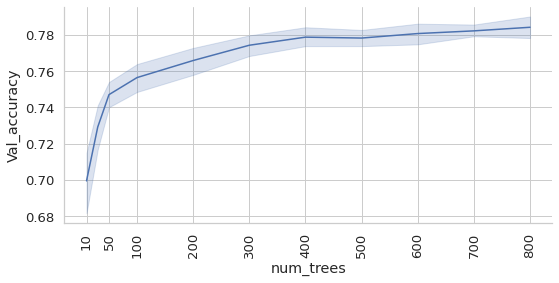

In [39]:
num_trees_small = [10 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800]
sns.set(font_scale=1.2 , style='whitegrid')
#sns.set_theme
g = sns.relplot(
    data = tree_score.reset_index(drop=True) , 
    kind= 'line' ,
    y= 'Val_accuracy',
    x = 'num_trees' , 
    height= 4 ,
    aspect= 8/4 , 
)
#g.set_xticks = num_trees
g.ax.set_xticks(num_trees_small)
g.ax.set_xticklabels(num_trees_small, rotation=90)
plt.show()

In [ ]:
num_trees = [10 , 30 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800]
max_depth = np.arange(1,15 , step=1)
depth_score = pd.DataFrame()
for n in tqdm(max_depth):
    clf = RandomForestClassifier(n_estimators = 500 , max_depth=n)
    res = calculate_score(clf , data_imp_norm)
    temp = pd.DataFrame({'Max_depth' : [n]*len(res) , 'Val_accuracy' : res})
    depth_score =  depth_score.append(temp)
depth_score

100%|██████████| 14/14 [04:44<00:00, 20.29s/it]


,Max_depth,Val_accuracy
0,1,0.444444
1,1,0.492063
2,1,0.452381
3,1,0.476190
4,1,0.428571
...,...,...
11,14,0.769841
12,14,0.801587
13,14,0.793651
14,14,0.777778


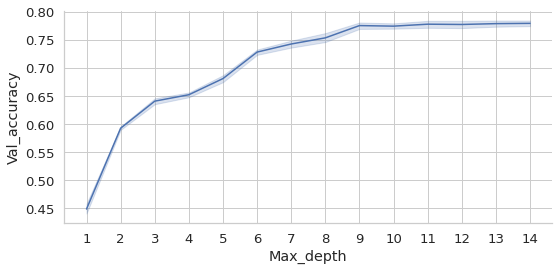

In [ ]:

sns.set(font_scale=1.2 , style='whitegrid')
#sns.set_theme
g = sns.relplot(
    data = depth_score.reset_index(drop=True) , 
    kind= 'line' ,
    y= 'Val_accuracy',
    x = 'Max_depth' , 
    height= 4 ,
    aspect= 8/4 , 
)
#g.set_xticks = num_trees
g.ax.set_xticks(max_depth)
g.ax.set_xticklabels(max_depth, rotation=0)
plt.show()

In [ ]:
min_split = np.arange(2, 8 , step =1)
split_score = pd.DataFrame()
for n in tqdm(min_split):
    clf = RandomForestClassifier(n_estimators = 500 , max_depth=11 , min_samples_split=n )
    res = calculate_score(clf , data_imp_norm)
    temp = pd.DataFrame({'Min sample split' : [n]*len(res) , 'Val_accuracy' : res})
    split_score =  split_score.append(temp)
depth_score

100%|██████████| 6/6 [02:20<00:00, 23.40s/it]


,Max_depth,Val_accuracy
0,1,0.444444
1,1,0.492063
2,1,0.452381
3,1,0.476190
4,1,0.428571
...,...,...
11,14,0.769841
12,14,0.801587
13,14,0.793651
14,14,0.777778


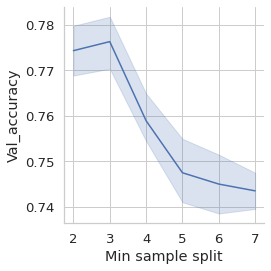

In [ ]:

sns.set(font_scale=1.2 , style='whitegrid')
#sns.set_theme
g = sns.relplot(
    data = split_score.reset_index(drop=True) , 
    kind= 'line' ,
    y= 'Val_accuracy',
    x = 'Min sample split' , 
    height= 4 ,
    aspect= 4/4 , 
)
#g.set_xticks = num_trees
g.ax.set_xticks(min_split)
g.ax.set_xticklabels(min_split, rotation=0)
plt.show()

In [40]:
min_split = np.arange(1, 8 , step =1)
leaf_score = pd.DataFrame()
for n in tqdm(min_split):
    clf = RandomForestClassifier(n_estimators = 500 , max_depth=11 , min_samples_split=3 , min_samples_leaf= n )
    res = calculate_score(clf , data_imp_norm)
    temp = pd.DataFrame({'Min sample leaf' : [n]*len(res) , 'Val_accuracy' : res})
    leaf_score =  leaf_score.append(temp)
leaf_score

  0%|          | 0/7 [00:02<?, ?it/s]


KeyboardInterrupt: 

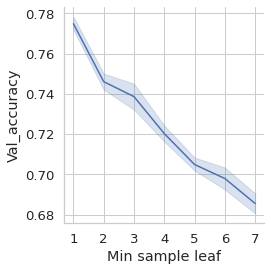

In [ ]:

sns.set(font_scale=1.2 , style='whitegrid')
#sns.set_theme
g = sns.relplot(
    data = leaf_score.reset_index(drop=True) , 
    kind= 'line' ,
    y= 'Val_accuracy',
    x = 'Min sample leaf' , 
    height= 4 ,
    aspect= 4/4 , 
)
#g.set_xticks = num_trees
g.ax.set_xticks(min_split)
g.ax.set_xticklabels(min_split, rotation=0)
plt.show()

# Tuned classifier

# Feature selection

In [41]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)

In [42]:
data_x = data_imp_norm.drop(columns=info_col_cl)
data_y = data_imp_norm['class']
data_i = data_imp_norm[info_col_cl]

In [43]:
from sklearn.inspection import permutation_importance

In [44]:
base_clf.fit(data_x , data_y)
res = permutation_importance(estimator = base_clf ,X = data_x , y = data_y )

In [45]:
res

{'importances_mean': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.38095238e-03, -2.22044605e-17,  3.33333333e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.52380952e-04,  0.00000000e+00,  0.00000000e+00,  1.90476190e-03,
        -2.22044605e-17,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.52380952e-04,  0.00000000e+00,  0.00000000e+00,
         1.42857143e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.42857143e-03,  0.00000000e+00,  0.00000000e+00,  1.09523810e-02,
         0.00000000e+00,  2.38095238e-03,  4.76190476e-03, -2.22044605e-17,
         0.00000000e+00]),
 'importances_std': array([0.        , 0.

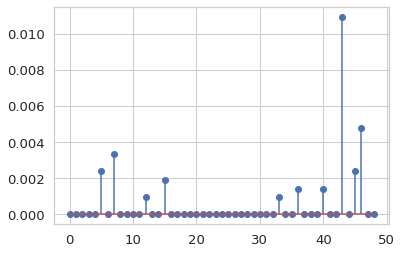

In [46]:
plt.stem(res['importances_mean'])
plt.show()

# Feature correlation

In [47]:
corr = data_x.corr()

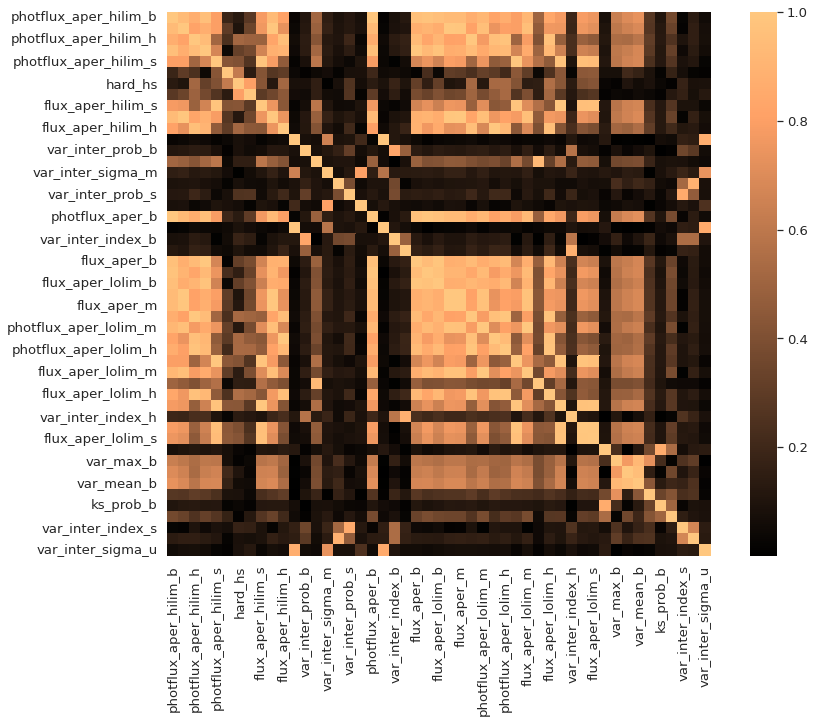

In [48]:
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize = (14,10) ,) 
sns.heatmap(corr.abs() , cmap = 'copper' , ax=  ax , square =True)
plt.show()

In [49]:
corr_abs = corr.abs()
for f in corr_abs.columns.to_list()[:2]:
    corr_feat = corr_abs[corr_abs[f]<0.75][f]
    display(corr_feat)

hard_hm                  0.185371
hard_hs                  0.130667
hard_ms                  0.284876
var_inter_sigma_b        0.030648
var_inter_prob_b         0.113761
photflux_aper_hilim_u    0.515326
var_inter_sigma_m        0.151025
var_inter_prob_m         0.094307
var_inter_prob_s         0.121020
var_inter_sigma_s        0.080632
var_inter_sigma_h        0.017429
var_inter_index_b        0.082303
var_inter_prob_h         0.123616
flux_aper_hilim_u        0.502365
var_inter_index_h        0.192542
kp_prob_b                0.082392
var_max_b                0.634842
var_min_b                0.698839
var_mean_b               0.730943
var_sigma_b              0.274144
ks_prob_b                0.109227
var_prob_b               0.366063
var_inter_index_s        0.026960
var_inter_index_m        0.138836
var_inter_sigma_u        0.056572
Name: photflux_aper_hilim_b, dtype: float64

hard_hm                  0.298687
hard_hs                  0.098747
hard_ms                  0.340967
flux_aper_hilim_h        0.733875
var_inter_sigma_b        0.041893
var_inter_prob_b         0.122671
photflux_aper_hilim_u    0.484988
var_inter_sigma_m        0.165585
var_inter_prob_m         0.096227
var_inter_prob_s         0.124600
var_inter_sigma_s        0.088678
var_inter_sigma_h        0.027355
var_inter_index_b        0.087889
var_inter_prob_h         0.104388
flux_aper_h              0.742833
flux_aper_hilim_u        0.457749
var_inter_index_h        0.187437
flux_aper_lolim_s        0.719160
kp_prob_b                0.100328
var_max_b                0.601283
var_min_b                0.655006
var_mean_b               0.688771
var_sigma_b              0.266590
ks_prob_b                0.123100
var_prob_b               0.331616
var_inter_index_s        0.017460
var_inter_index_m        0.153767
var_inter_sigma_u        0.072357
Name: photflux_aper_hilim_m, dtype: float64

In [50]:
curr_list = corr_abs.columns.to_list()

In [51]:
cor_matrix = data_x.corr().abs()

In [52]:
upper_tri = cor_matrix.where(np.tril(np.ones(cor_matrix.shape),k=-1).astype(np.bool))
display(upper_tri)

,photflux_aper_hilim_b,photflux_aper_hilim_m,photflux_aper_hilim_h,flux_aper_hilim_b,photflux_aper_hilim_s,hard_hm,hard_hs,hard_ms,flux_aper_hilim_s,flux_aper_hilim_m,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
photflux_aper_hilim_b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
photflux_aper_hilim_m,0.935714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
photflux_aper_hilim_h,0.873029,0.816589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flux_aper_hilim_b,0.958639,0.872543,0.944856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
photflux_aper_hilim_s,0.797535,0.800324,0.515477,0.673171,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hard_hm,0.185371,0.298687,0.241658,0.044028,0.428172,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hard_hs,0.130667,0.098747,0.518815,0.323265,0.409648,0.619001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hard_ms,0.284876,0.340967,0.494252,0.369678,0.259660,0.138584,0.801852,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flux_aper_hilim_s,0.778308,0.759397,0.488871,0.661561,0.980772,0.421910,0.428579,0.290456,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flux_aper_hilim_m,0.936210,0.995948,0.827096,0.881928,0.787154,0.273928,0.118020,0.353166,0.751736,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


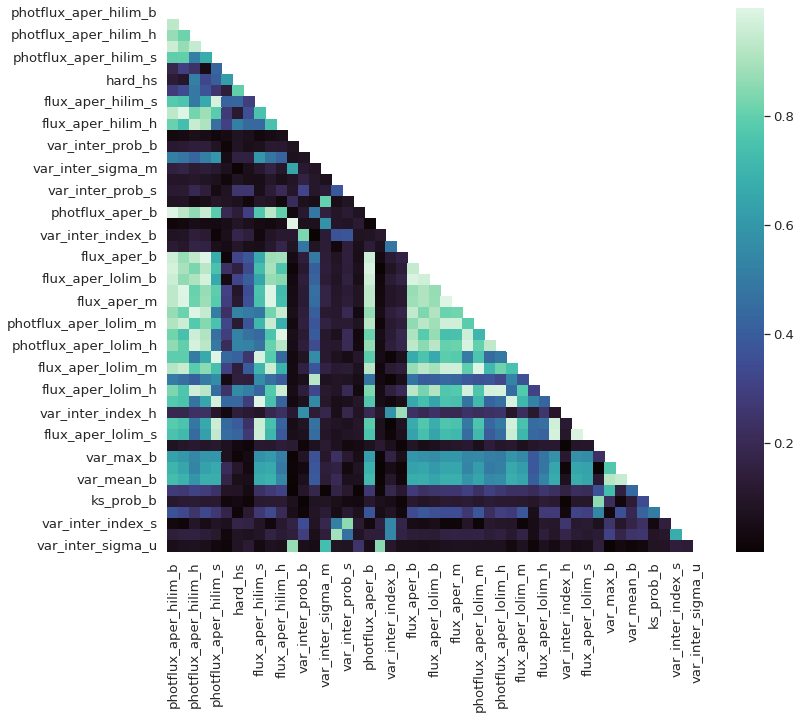

In [53]:
plt.figure(figsize=(12,10))
sns.heatmap(upper_tri , cmap='mako' ,)
plt.show()

In [54]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(len(to_drop))

30


In [55]:
to_drop

['photflux_aper_hilim_b',
 'photflux_aper_hilim_m',
 'photflux_aper_hilim_h',
 'flux_aper_hilim_b',
 'photflux_aper_hilim_s',
 'flux_aper_hilim_s',
 'flux_aper_hilim_m',
 'flux_aper_hilim_h',
 'var_inter_sigma_b',
 'photflux_aper_hilim_u',
 'var_inter_prob_m',
 'var_inter_prob_s',
 'photflux_aper_b',
 'var_inter_sigma_h',
 'var_inter_prob_h',
 'flux_aper_b',
 'photflux_aper_lolim_b',
 'flux_aper_lolim_b',
 'photflux_aper_m',
 'flux_aper_m',
 'photflux_aper_h',
 'photflux_aper_lolim_m',
 'flux_aper_h',
 'photflux_aper_lolim_h',
 'photflux_aper_s',
 'flux_aper_s',
 'photflux_aper_lolim_s',
 'kp_prob_b',
 'var_max_b',
 'var_min_b']

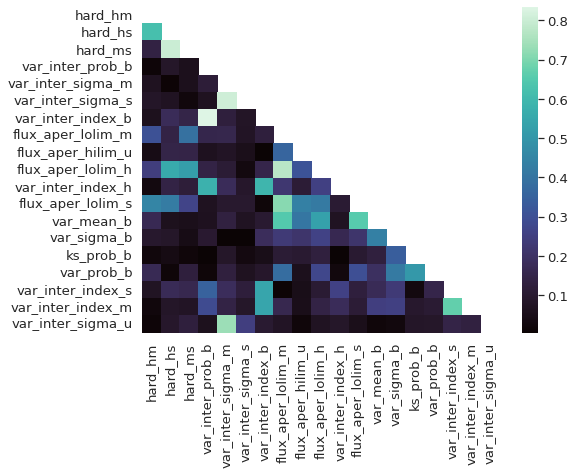

In [56]:
x_val_small = x_val.drop(columns=to_drop)
corr_small = x_val_small.corr().abs()
upper_tri_small = corr_small.where(np.tril(np.ones(corr_small.shape),k=-1).astype(np.bool))
plt.figure(figsize=(8,6))
sns.heatmap(upper_tri_small , cmap='mako' ,)
plt.show()

In [94]:
len(upper_tri_small.columns.to_list())

19

In [95]:
data_i

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class
obs_id,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV
...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX


In [96]:
data_y

obs_id
CV_0_obs_0       CV
CV_1_obs_0       CV
CV_2_obs_0       CV
CV_3_obs_0       CV
CV_4_obs_0       CV
                 ..
LMXB_86_obs_0    LX
LMXB_90_obs_0    LX
LMXB_91_obs_0    LX
LMXB_92_obs_0    LX
LMXB_94_obs_0    LX
Name: class, Length: 420, dtype: object

In [97]:
x_val_small

,hard_hm,hard_hs,hard_ms,var_inter_prob_b,var_inter_sigma_m,var_inter_sigma_s,var_inter_index_b,flux_aper_lolim_m,flux_aper_hilim_u,flux_aper_lolim_h,var_inter_index_h,flux_aper_lolim_s,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,1.221230,-1.140730,-1.548716,0.690896,-0.043767,0.006219,0.138758,1.382589,-1.543953,1.105853,0.851765,0.728190,-0.409996,0.042725,-0.250447,0.492569,0.200236,-0.756434,0.168818
CV_1_obs_0,-0.642970,-0.661574,-0.432270,0.657741,-0.205272,-0.115184,0.138758,0.322936,-0.114667,0.498898,-0.511538,-0.134693,-0.450546,-0.153447,0.182504,0.710415,0.200236,-0.795530,-0.096487
CV_2_obs_0,0.787312,-0.976056,-1.202268,-3.374789,-0.213739,-0.113942,-1.564672,1.326455,0.435977,1.084401,-1.517201,0.593645,-0.471439,-0.166164,0.404797,0.577944,-0.948770,-0.265416,-0.096436
CV_3_obs_0,-0.216734,-0.437157,-0.402485,0.690896,-0.203826,-0.115123,1.274378,-0.133495,-0.042408,-0.036514,-0.008706,-0.488349,-0.351673,-0.240642,-0.832196,-0.778104,0.774739,1.855039,-0.096581
CV_4_obs_0,1.240359,0.185857,-0.908350,0.690896,-0.213134,-0.117155,1.274378,1.067539,0.457206,0.240594,0.996957,0.402822,-0.364175,-0.128738,0.147528,0.641022,-0.948770,-0.265416,-0.096428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,-0.770742,-0.921567,-0.556991,0.668765,0.238136,0.065465,-0.025907,-0.259728,-0.262113,0.172315,0.881306,-0.629129,-0.373279,-0.343210,1.114425,-1.386978,0.263431,-0.779626,-0.086540
LMXB_90_obs_0,0.352663,-0.932273,-1.218356,0.669179,0.137340,0.081174,-0.048619,0.977215,0.330727,0.949888,0.886334,-0.153310,-0.548922,-0.269642,-1.340299,1.704492,0.200236,-0.779626,-0.086412
LMXB_91_obs_0,-1.679225,0.435324,1.775157,-1.319152,-0.214220,-0.119638,-1.564672,-0.345176,1.162099,1.065110,-1.517201,1.358513,-0.514178,-0.283957,0.705305,0.182274,-0.948770,0.264698,-0.096551


In [98]:
df_small = pd.concat([data_i , x_val_small] , axis=1)
df_small

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,flux_aper_lolim_h,var_inter_index_h,flux_aper_lolim_s,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,1.105853,0.851765,0.728190,-0.409996,0.042725,-0.250447,0.492569,0.200236,-0.756434,0.168818
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.498898,-0.511538,-0.134693,-0.450546,-0.153447,0.182504,0.710415,0.200236,-0.795530,-0.096487
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,1.084401,-1.517201,0.593645,-0.471439,-0.166164,0.404797,0.577944,-0.948770,-0.265416,-0.096436
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,-0.036514,-0.008706,-0.488349,-0.351673,-0.240642,-0.832196,-0.778104,0.774739,1.855039,-0.096581
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.240594,0.996957,0.402822,-0.364175,-0.128738,0.147528,0.641022,-0.948770,-0.265416,-0.096428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.172315,0.881306,-0.629129,-0.373279,-0.343210,1.114425,-1.386978,0.263431,-0.779626,-0.086540
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.949888,0.886334,-0.153310,-0.548922,-0.269642,-1.340299,1.704492,0.200236,-0.779626,-0.086412
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,1.065110,-1.517201,1.358513,-0.514178,-0.283957,0.705305,0.182274,-0.948770,0.264698,-0.096551


In [100]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
res =  calculate_score(base_clf , df_small)

In [101]:
res 

[0.7619047619047619,
 0.7619047619047619,
 0.753968253968254,
 0.7777777777777778,
 0.746031746031746,
 0.753968253968254,
 0.746031746031746,
 0.7619047619047619,
 0.7698412698412699,
 0.7301587301587301,
 0.753968253968254,
 0.7698412698412699,
 0.7777777777777778,
 0.753968253968254,
 0.7301587301587301,
 0.7777777777777778]

In [102]:
print(np.mean(res) , np.std(res))

0.7579365079365079 0.014580296087995123


In [103]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
res_og =  calculate_score(base_clf , data_imp_norm)

In [104]:
res_og 

[0.6984126984126984,
 0.6984126984126984,
 0.6984126984126984,
 0.6984126984126984,
 0.6904761904761905,
 0.6746031746031746,
 0.6984126984126984,
 0.7222222222222222,
 0.7063492063492064,
 0.7063492063492064,
 0.6904761904761905,
 0.6746031746031746,
 0.7222222222222222,
 0.7063492063492064,
 0.6904761904761905,
 0.7222222222222222]

In [105]:
print(np.mean(res_og) , np.std(res_og))

0.6999007936507936 0.01409114356283907


In [106]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
base_clf.fit(x_val_small  , data_y)
res = permutation_importance(estimator=base_clf , X=x_val_small , y = data_y)

KeyboardInterrupt: 

In [107]:
res

[0.7619047619047619,
 0.7619047619047619,
 0.753968253968254,
 0.7777777777777778,
 0.746031746031746,
 0.753968253968254,
 0.746031746031746,
 0.7619047619047619,
 0.7698412698412699,
 0.7301587301587301,
 0.753968253968254,
 0.7698412698412699,
 0.7777777777777778,
 0.753968253968254,
 0.7301587301587301,
 0.7777777777777778]

In [108]:
plt.stem(res['importances_mean'])
plt.show()

TypeError: list indices must be integers or slices, not str

In [ ]:
np.linspace(0.5 , 0.95 , num=10)

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [109]:
res_mean = []
res_var = []
num_feat = []
for f in tqdm(np.linspace(0.5 , 0.95 , num=10)):
    cor_matrix = data_x.corr().abs()
    upper_tri = cor_matrix.where(np.tril(np.ones(cor_matrix.shape),k=-1).astype(np.bool))
    #display(upper_tri)
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > f)]
    print(len(to_drop))
    x_val = data_imp_norm.drop(columns = info_col_cl)
    y_val = data_imp_norm['class']
    i_val = data_imp_norm[info_col_cl]
    x_val_small = x_val.drop(columns=to_drop)
    print('num of feat' , x_val_small.shape[1])
    num_feat.append(x_val_small.shape[1])
    corr_small = x_val_small.corr().abs()
    upper_tri_small = corr_small.where(np.tril(np.ones(corr_small.shape),k=-1).astype(np.bool))
    #plt.figure(figsize=(8,6))
    ##sns.heatmap(upper_tri_small , cmap='mako' ,)
    #plt.show()
    df_small = pd.concat([data_i , x_val_small] , axis=1)
    df_small
    base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
    res =  calculate_score(base_clf , df_small)
    print(np.mean(res) , np.std(res))
    res_mean.append(np.mean(res))
    res_var.append(np.std(res))

  0%|          | 0/10 [00:00<?, ?it/s]

42


KeyError: "['photflux_aper_hilim_b' 'photflux_aper_hilim_m' 'photflux_aper_hilim_h'\n 'flux_aper_hilim_b' 'photflux_aper_hilim_s' 'flux_aper_hilim_s'\n 'flux_aper_hilim_m' 'flux_aper_hilim_h' 'var_inter_sigma_b'\n 'photflux_aper_hilim_u' 'var_inter_prob_m' 'var_inter_prob_s'\n 'photflux_aper_b' 'var_inter_sigma_h' 'var_inter_prob_h' 'flux_aper_b'\n 'photflux_aper_lolim_b' 'flux_aper_lolim_b' 'photflux_aper_m'\n 'flux_aper_m' 'photflux_aper_h' 'photflux_aper_lolim_m' 'flux_aper_h'\n 'photflux_aper_lolim_h' 'photflux_aper_s' 'flux_aper_s'\n 'photflux_aper_lolim_s' 'kp_prob_b' 'var_max_b' 'var_min_b'] not found in axis"

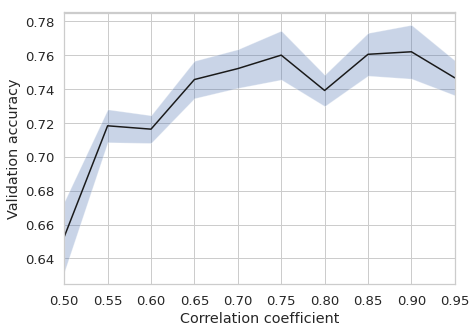

In [ ]:
res_mean = np.asarray(res_mean)
res_var =  np.asarray(res_var)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot( 111 )
plt.plot(np.linspace(0.5 , 0.95 , num=10) , res_mean ,color='k')
plt.fill_between(x = np.linspace(0.5 , 0.95 , num=10) , y1 = res_mean+res_var , y2 = res_mean-res_var , alpha = 0.3)
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticks(num_feat)
plt.xlim(0.5, 0.95)
plt.xlabel('Correlation coefficient')
plt.ylabel('Validation accuracy')
plt.show()

In [ ]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
base_clf.fit(x_val_small  , data_y)
res = permutation_importance(estimator=base_clf , X=x_val_small , y = data_y)

{'importances_mean': array([0.01428571, 0.00380952, 0.00285714, 0.00285714, 0.00190476,
        0.00238095, 0.01285714, 0.00238095, 0.00238095, 0.00571429,
        0.00190476, 0.0047619 , 0.00380952, 0.0047619 , 0.0047619 ,
        0.00285714, 0.0047619 , 0.0047619 , 0.00238095, 0.00809524,
        0.00380952, 0.01238095, 0.00238095, 0.00761905, 0.0047619 ,
        0.00190476, 0.00190476]),
 'importances_std': array([0.00336718, 0.00116642, 0.00095238, 0.00095238, 0.00095238,
        0.00150585, 0.00441601, 0.00150585, 0.        , 0.00116642,
        0.00095238, 0.00212959, 0.00116642, 0.00150585, 0.00212959,
        0.00095238, 0.00150585, 0.        , 0.        , 0.00285714,
        0.00190476, 0.00380952, 0.        , 0.00233285, 0.00150585,
        0.00233285, 0.00095238]),
 'importances': array([[ 0.01190476,  0.01666667,  0.01904762,  0.01428571,  0.00952381],
        [ 0.0047619 ,  0.0047619 ,  0.00238095,  0.0047619 ,  0.00238095],
        [ 0.00238095,  0.00238095,  0.00238095, 

## One vs rest feature importance

In [ ]:
x_val = data_imp_norm.drop(columns = info_col_cl)
y_val = data_imp_norm['class']
i_val = data_imp_norm[info_col_cl]
cor_matrix = x_val.corr().abs()
upper_tri = cor_matrix.where(np.tril(np.ones(cor_matrix.shape),k=-1).astype(np.bool))
#display(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(len(to_drop))
x_val_small = x_val.drop(columns=to_drop)

30


In [ ]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
data_y_cv_rest =  data_y.replace({'CV' : 'NONCV' , 'PL' : 'NONCV'})
base_clf.fit(x_val_small  , data_y)
res = permutation_importance(estimator=base_clf , X=x_val_small , y = data_y_cv_rest , n_repeats=40 , n_jobs=-1)
res_df = pd.DataFrame(res['importances'].T , columns=x_val_small.columns.to_list() )
res_df = res_df.describe().loc[['mean' ,'std']].T.sort_values(by='mean', ascending=False)
res_df_lx = res_df.rename(columns= {'mean':'mean_LMXB' , 'std':'std_LMXB'})

In [ ]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
data_y_cv_rest =  data_y.replace({'LX' : 'NONCV' , 'PL' : 'NONCV'})
base_clf.fit(x_val_small  , data_y)
res = permutation_importance(estimator=base_clf , X=x_val_small , y = data_y_cv_rest , n_repeats=40 , n_jobs=-1)
res_df = pd.DataFrame(res['importances'].T , columns=x_val_small.columns.to_list() )
res_df = res_df.describe().loc[['mean' ,'std']].T.sort_values(by='mean', ascending=False)
res_df_cv = res_df.rename(columns={'mean':'mean_CV' , 'std':'std_CV'})

In [ ]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
data_y_cv_rest =  data_y.replace({'LX' : 'NONCV' , 'CV' : 'NONCV'})
base_clf.fit(x_val_small  , data_y)
res = permutation_importance(estimator=base_clf , X=x_val_small , y = data_y_cv_rest , n_repeats=40, n_jobs=-1)
res_df = pd.DataFrame(res['importances'].T , columns=x_val_small.columns.to_list() )
res_df = res_df.describe().loc[['mean' ,'std']].T.abs().sort_values(by='mean', ascending=False)
res_df_pl = res_df.rename(columns = {'mean':'mean_PULSAR' , 'std':'std_PULSAR'})

In [ ]:
res_df_lx = res_df_lx.rename(columns={'mean':'mean_LX' , 'std':'std_LMXB'})
res_df_cv = res_df_cv.rename(columns={'mean':'mean_CV' , 'std':'std_CV'})
res_df_pl = res_df_pl.rename(columns={'mean':'mean_PULSAR' , 'std':'std_PULSAR'})

In [ ]:
res_df_all = pd.concat([res_df_cv , res_df_lx, res_df_pl] , axis=1)
res_df_all

,mean_CV,std_CV,mean_LMXB,std_LMXB,mean_PULSAR,std_PULSAR
hard_hm,0.001607,0.002608,0.007083,0.002255,0.011548,0.003029
hard_hs,0.001369,0.001779,0.000238,0.000723,0.003750,0.001936
var_prob_b,0.000774,0.001363,0.003452,0.002085,0.008214,0.002951
hard_ms,0.000655,0.001319,0.003452,0.001520,0.006310,0.002617
var_inter_index_h,0.000476,0.000965,0.001726,0.001524,0.006071,0.002799
flux_aper_lolim_h,0.000357,0.000861,0.001726,0.001616,0.002381,0.001705
var_inter_sigma_u,0.000179,0.000635,0.001786,0.001595,0.004286,0.002170
var_inter_sigma_m,0.000060,0.000376,0.002440,0.001571,0.001667,0.001959
var_mean_b,0.000060,0.000376,0.003988,0.001465,0.004940,0.001819
var_inter_index_b,0.000000,0.000000,0.000000,0.000000,0.001131,0.002156


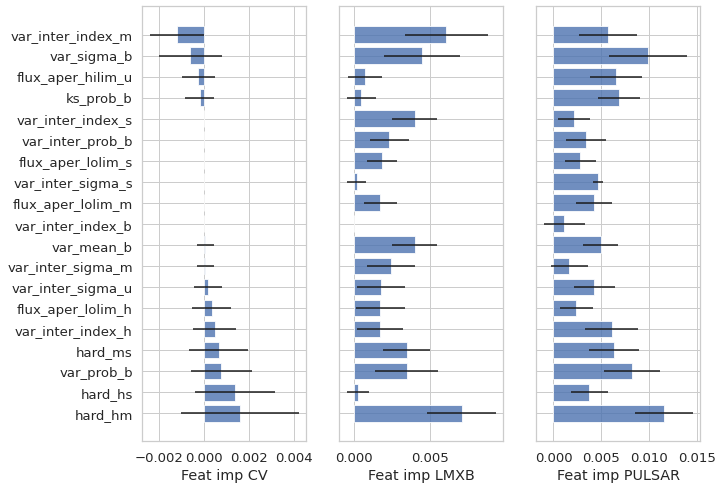

In [ ]:
fig , ax = plt.subplots(nrows = 1 , ncols=3 ,  figsize=(10,8) , sharey=True )
sns.set_style("whitegrid", {'axes.grid' : True})
ax[0].barh( res_df_all.index.to_list()  , res_df_all['mean_CV'] , xerr=res_df_all['std_CV'] , alpha= 0.8)
ax[0].set_xlabel('Feat imp CV')
ax[1].barh( res_df_all.index.to_list() , res_df_all['mean_LMXB'] ,xerr=res_df_all['std_LMXB']  ,   alpha= 0.8)
ax[1].set_xlabel('Feat imp LMXB')
ax[2].barh(  res_df_all.index.to_list() , res_df_all['mean_PULSAR'] , xerr=res_df_all['std_PULSAR'] ,   alpha= 0.8)
ax[2].set_xlabel('Feat imp PULSAR')
plt.show()

In [ ]:
base_clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
#data_y_cv_rest =  data_y.replace({'LX' : 'NONCV' , 'CV' : 'NONCV'})
base_clf.fit(x_val_small  , data_y)
res = permutation_importance(estimator=base_clf , X=x_val_small , y = data_y , n_repeats=40, n_jobs=-1)
res_df = pd.DataFrame(res['importances'].T , columns=x_val_small.columns.to_list() )
res_df = res_df.describe().loc[['mean' ,'std']].T.abs().sort_values(by='mean', ascending=False)
#res_df_pl = res_df.rename(columns = {'mean':'mean_PULSAR' , 'std':'std_PULSAR'})

In [ ]:
res_df = res_df.sort_values(by='mean' , ascending=True)

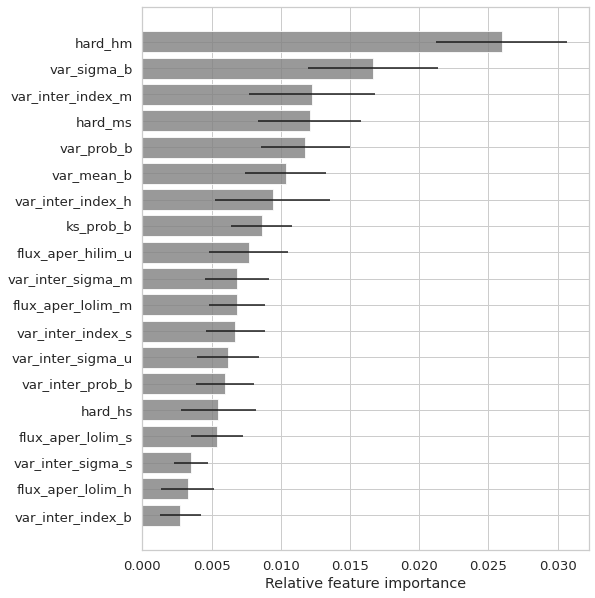

In [ ]:
fig , ax = plt.subplots(nrows = 1 , ncols=1 ,  figsize=(8,10) , sharey=True )
ax.barh( res_df.index.to_list()  , res_df['mean'] , xerr=res_df['std'] , alpha= 0.8 ,color='gray')
#ax.set_xticklabels(ax.get_xticklabels() , rotation=45)
ax.set_xlabel('Relative feature importance')
plt.show()

# Permutation significance

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score


In [ ]:
x_val = data_imp_norm.drop(columns = info_col_cl)
y_val = data_imp_norm['class']
i_val = data_imp_norm[info_col_cl]
cor_matrix = x_val.corr().abs()
upper_tri = cor_matrix.where(np.tril(np.ones(cor_matrix.shape),k=-1).astype(np.bool))
#display(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(len(to_drop))
x_val_small = x_val.drop(columns=to_drop)


30


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
cv = StratifiedShuffleSplit(5,test_size=0.3 , random_state=0)
clf = RandomForestClassifier(n_estimators=500  , max_depth= 10 , min_samples_split= 3, min_samples_leaf= 1 , oob_score=True)
score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, x_val_small, y_val, scoring="accuracy", cv=cv, n_permutations=500 , n_jobs=-1 , 
)


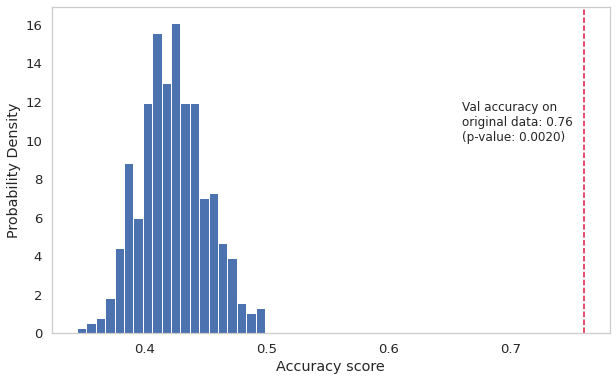

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style({'axes.grid' : False})
ax.hist(perm_scores_iris, bins=20, density=True )
ax.axvline(0.76, ls="--", color="crimson")
score_label = f"Val accuracy on\noriginal data: {0.76:.2f}\n(p-value: {pvalue_iris:.4f})"
ax.text(0.66, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability Density")